In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import torch
from skimage import exposure
from scipy.ndimage import label
import math

In [3]:
def save_video_from_images(images, output_filename, fps=60):
    """
    Save a sequence of images as a video.

    Parameters:
    images (list or array): List or array of images (each image should be a 2D or 3D NumPy array).
    output_filename (str): Output video filename (e.g., 'output.avi').
    fps (int): Frames per second for the video.
    """
    # Get the dimensions of the images
    height, width = images[0].shape[:2]

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_filename, fourcc, fps, (width, height))

    for img in images:
        # Ensure image is in the correct format (uint8)
        img_uint8 = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        # If the image is grayscale, convert it to BGR
        if len(img_uint8.shape) == 2:
            img_uint8 = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2BGR)
        out.write(img_uint8)

    # Release everything when the job is finished
    out.release()

In [4]:
scene_df1 = pd.read_hdf('scene.hdf5')
scene_df2 = pd.read_hdf('scene2.hdf5')
scene_df3 = pd.read_hdf('scene3.hdf5')
car_scene_df1 = pd.read_hdf('car_scene.hdf5')
car_scene_df2 = pd.read_hdf('car_scene2.hdf5')
car_scene_df3 = pd.read_hdf('car_scene3.hdf5')

In [5]:
def slice_array(arr, num = 10):
    t, x, y = arr.shape
    
    # Ensure x and y are divisible by 10
    assert x % num == 0 and y % num == 0, "Dimensions x and y must be divisible by 10"
    
    slices = []
    
    for i in range(num):
        for j in range(num):
            slice_x_start = i * (x // num)
            slice_x_end = (i + 1) * (x // num)
            slice_y_start = j * (y // num)
            slice_y_end = (j + 1) * (y // num)
            
            slice_ij = arr[:, slice_x_start:slice_x_end, slice_y_start:slice_y_end]
            slices.append(slice_ij)
    
    return slices

def rebuild_array(slices, original_shape, num = 10):
    x, y = original_shape
    
    # Initialize an empty array with the original shape
    rebuilt_array = np.zeros(( x, y))
    
    for idx, slice_ij in enumerate(slices):
        i = idx // num
        j = idx % num
   
        slice_x_start = i * (x // num)
        slice_x_end = (i + 1) * (x // num)
        slice_y_start = j * (y // num)
        slice_y_end = (j + 1) * (y // num)
        
        rebuilt_array[slice_x_start:slice_x_end, slice_y_start:slice_y_end] = slice_ij
    
    return rebuilt_array

In [6]:
def sorted_uniform_pictures(arr):
    """
    Sort (t, x, y) array's t slices from most uniform to least uniform.

    Parameters:
    arr (np.ndarray): Input 3D array of shape (t, x, y).

    Returns:
    np.ndarray: A 3D array where the t slices are sorted by uniformity.
    """
    t, x, y = arr.shape
    
    # Compute the variance for each t slice
    variances = np.var(arr, axis=(1, 2))
    
    # Get the sorted indices based on variances
    sorted_indices = np.argsort(variances)
    
    # Extract and sort the t slices
    sorted_slices = arr[sorted_indices]
    
    return sorted_slices

In [7]:
def sorted_least_mean_pictures(arr):
    """
    Sort (t, x, y) array's t slices from most uniform to least uniform.

    Parameters:
    arr (np.ndarray): Input 3D array of shape (t, x, y).

    Returns:
    np.ndarray: A 3D array where the t slices are sorted by uniformity.
    """
    t, x, y = arr.shape
    
    # Compute the variance for each t slice
    means = np.mean(arr, axis=(1, 2))
    
    # Get the sorted indices based on variances
    sorted_indices = np.argsort(means)
    
    # Extract and sort the t slices
    sorted_slices = arr[sorted_indices]
    
    return sorted_slices

In [8]:
def pick_regular_slices(arr,num):
    """
    Pick a tenth of all t slices in a regular order from a (t, x, y) array.

    Parameters:
    arr (np.ndarray): Input 3D array of shape (t, x, y).

    Returns:
    np.ndarray: A 3D array with a tenth of the t slices picked in a regular order.
    """
    t, x, y = arr.shape
    
    # Compute the indices to pick a tenth of the t slices at regular intervals
    step = t // num
    indices = np.arange(0, t, step)
    
    # Pick slices at the computed indices
    picked_slices = arr[indices]
    
    return picked_slices

In [9]:
def adjust_mean_to_target(arr, target_mean):
    """
    Adjust the values of a 2D array uniformly so that its mean is as close as possible to a target value.

    Parameters:
    arr (np.ndarray): Input 2D array.
    target_mean (float): Target mean value.

    Returns:
    np.ndarray: Adjusted 2D array.
    """
    current_mean = np.mean(arr)
    difference = target_mean - current_mean
    adjusted_array = arr - difference
    return adjusted_array

In [11]:
def pseud_calibration(arr, num_slices, reg= 100,adjust =None):

    slices = slice_array(arr, num_slices)
    _, x, y = arr.shape
    medslice = [sorted_uniform_pictures(s) for s in slices]
    original_means = [np.mean(s) for s in slices]

    print(medslice[0].shape)
    tenth = [pick_regular_slices(s,reg) for s in medslice]
    meaned = [np.mean(t, axis=0) for t in tenth]
    if adjust is not None:
        adjusted = [adjust_mean_to_target(m, adjust) for m in meaned]
    return rebuild_array(meaned, (x, y), num_slices)

arr1 = np.stack(scene_df1["image"].values)
filter_scene = pseud_calibration(arr1,32)
#filter_scene = adjust_mean_to_target(filter, 200)

arr2 = np.stack(car_scene_df2["image"].values)
filter_car_scene = pseud_calibration(arr2,32)
#filter_car_scene = adjust_mean_to_target(filter_car_scene, 200)

(400, 15, 20)
(1001, 15, 20)


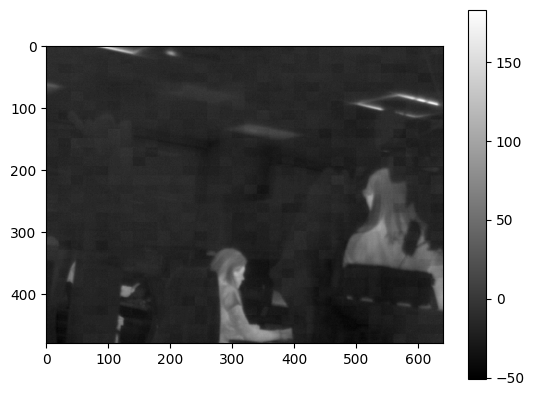

In [15]:
corrected = arr1-filter_scene
num =-100

plt.imshow(corrected[num], cmap='gray')
plt.colorbar()

plt.show()



In [43]:
all_vids = [scene_df1,scene_df2,scene_df3]
for i, scene in enumerate(all_vids):
    name = f"adjuested_Transfered_pseudo_calibration_scenes_{i+1}.avi"
    vid = np.stack(scene["image"].values)
    vid = adjust_mean_to_target(vid, 200)
    save_video_from_images(vid-filter_scene, name)

all_vids2 = [car_scene_df1,car_scene_df2, car_scene_df3]
for i, scene in enumerate(all_vids2):
    name = f"adjusted_Transfered_pseudo_calibration_car_scenes_{i+1}.avi"
    vid = np.stack(scene["image"].values)
    vid = adjust_mean_to_target(vid, 200)
    save_video_from_images(vid-filter_car_scene, name)